<a href="https://colab.research.google.com/github/niuguy/digithealthcourse/blob/master/Mortality-prediction-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mortality prediction - feature engineering

The aim of the feature engineering:

**Creating**: Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. In this task, we will create at least one new feature to see if it plays a role.

**Converting**: The raw dataset is always not ready for analysis, some features need to be converted, or be normalized to meet the requirements. Besides, before we feed the training dataset into prediction/classification models, all datatypes need to be converted to numerical values for mathematical computation.

**Completing**. Data preparation may also require us to estimate any missing values within a feature. Model algorithms may work best when there are no missing values.

**Correcting**. We may also analyze the given training dataset for errors or possibly innacurate values within features and try to corrent these values or exclude the samples containing the errors. One way to do this is to detect any outliers among our samples or features. 

**Correlating**. One can approach the problem based on available features within the training dataset. Which features within the dataset contribute significantly to our solution goal? As the feature values change does the solution state change as well, and visa-versa? This can be tested both for numerical and categorical features in the given dataset.


## Data preparation

<!-- * We have a hyposis here that the patients who have a lot of interactions during his/her stay at hospital tend to have a high risk of mortality. -->
* The dataset for this task is the admission records as well as value counts of interactions/events happened during each admission.
* The related tables include labevents(Events relating to laboratory tests), microbiologyevents(Events relating to microbiology tests), callouts(Record of when patients were ready for discharge), inputevents(Events relating to fluid input for patients ), outputevents(Outputs recorded during the ICU stay), diagnosis(Diagnoses relating to a hospital admission coded using the ICD9 system), transfers(Location of patients during their hospital stay), cptevents(Events recorded in Current Procedural Terminology)
* We first calculate the count of each event table, then the results are linked to the admission table 

The schema for reference https://mit-lcp.github.io/mimic-schema-spy/ )

The SQL for doing so is below: (You can run it from your bigquery console)


``` SQL
WITH 
callout as (select HADM_ID, count(HADM_ID) as CALLOUT_COUNT from  `physionet-data.mimiciii_clinical.callout` group by HADM_ID),
diags as (select HADM_ID, count(HADM_ID) as DIAG_COUNT from `physionet-data.mimiciii_clinical.diagnoses_icd` group by HADM_ID),
preps as (select HADM_ID, count(HADM_ID) as PRES_COUNT from `physionet-data.mimiciii_clinical.prescriptions` group by HADM_ID),
procs as (select HADM_ID, count(HADM_ID) as PROC_COUNT from `physionet-data.mimiciii_clinical.procedures_icd` group by HADM_ID),
cpts as (select HADM_ID, count(HADM_ID) as CPT_COUNT from `physionet-data.mimiciii_clinical.cptevents` group by HADM_ID),
labs as (select HADM_ID, count(HADM_ID) as LAB_COUNT from `physionet-data.mimiciii_clinical.labevents` group by HADM_ID),
inputs_cv as (select HADM_ID, count(HADM_ID) as INPUTS_CV_COUNT from `physionet-data.mimiciii_clinical.inputevents_cv` group by HADM_ID),
inputs_mv as (select HADM_ID, count(HADM_ID) as INPUTS_MV_COUNT from `physionet-data.mimiciii_clinical.inputevents_mv` group by HADM_ID),
outputs as (select HADM_ID, count(HADM_ID) as OUTPUT_COUNT from `physionet-data.mimiciii_clinical.outputevents` group by HADM_ID),
transfers as (select HADM_ID, count(HADM_ID) as TRANSFER_COUNT from `physionet-data.mimiciii_clinical.transfers` group by HADM_ID),
micros as (select HADM_ID, count(HADM_ID) as MICRO_COUNT from `physionet-data.mimiciii_clinical.microbiologyevents` group by HADM_ID)
SELECT adm.SUBJECT_ID, adm.HADM_ID, adm.ADMISSION_TYPE,adm.ADMITTIME, adm.DISCHTIME,adm.DEATHTIME, adm.DIAGNOSIS, adm.MARITAL_STATUS,adm.INSURANCE, adm.LANGUAGE, adm.RELIGION, adm.ETHNICITY,pts.GENDER, pts.DOB, stays.LOS, callout.CALLOUT_COUNT, diags.DIAG_COUNT,preps.PRES_COUNT,procs.PROC_COUNT,cpts.CPT_COUNT, labs.LAB_COUNT, inputs_cv.INPUTS_CV_COUNT, inputs_mv.INPUTS_MV_COUNT, outputs.OUTPUT_COUNT, transfers.TRANSFER_COUNT, micros.MICRO_COUNT
FROM `physionet-data.mimiciii_clinical.admissions` as adm
left join `physionet-data.mimiciii_clinical.patients` as pts on adm.SUBJECT_ID = pts.SUBJECT_ID
left join `physionet-data.mimiciii_clinical.icustays` as stays on adm.HADM_ID = stays.HADM_ID
left join callout on adm.HADM_ID = callout.HADM_ID
left join diags on adm.HADM_ID = diags.HADM_ID
left join preps on adm.HADM_ID = preps.HADM_ID
left join procs on adm.HADM_ID = procs.HADM_ID
left join cpts on adm.HADM_ID = cpts.HADM_ID
left join labs on adm.HADM_ID = labs.HADM_ID
left join inputs_cv on adm.HADM_ID = inputs_cv.HADM_ID
left join inputs_mv on adm.HADM_ID = inputs_mv.HADM_ID
left join outputs on adm.HADM_ID = outputs.HADM_ID
left join transfers on adm.HADM_ID = transfers.HADM_ID
left join micros on adm.HADM_ID = micros.HADM_ID
```

If you run this SQL on your Bigquery and save the results to your google drive,  we can load it into Pandas dataframe for analysis.

In [0]:
import pandas as pd
import numpy as np

In [0]:
df_m3 = pd.read_csv('/content/drive/My Drive/bq-results-20200212-103045-ose0m5jaxgto/bq-results-20200212-103045-ose0m5jaxgto.csv')

Check the first 5 rows with head() 



In [14]:
df_m3.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,NaN,18.0,NaN,3,47.0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,NaN,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,NaN,9,NaN,9.0,NaN,408.0,331.0,NaN,89.0,3,27.0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,NaN,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,NaN,9,NaN,8.0,NaN,574.0,390.0,NaN,90.0,6,46.0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,NaN,21.0,20.0,4,NaN
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,NaN,22,53.0,6.0,10.0,378.0,165.0,NaN,115.0,7,5.0


We have a bunch of columns , if we'd like to look at them closely, we can use .columns

In [15]:
df_m3.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'DIAGNOSIS', 'MARITAL_STATUS', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'ETHNICITY', 'GENDER', 'DOB', 'LOS', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT'],
      dtype='object')

We could print the general information of this dataframe

In [16]:
df_m3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62722 entries, 0 to 62721
Data columns (total 26 columns):
SUBJECT_ID         62722 non-null int64
HADM_ID            62722 non-null int64
ADMISSION_TYPE     62722 non-null object
ADMITTIME          62722 non-null object
DISCHTIME          62722 non-null object
DEATHTIME          6650 non-null object
DIAGNOSIS          62697 non-null object
MARITAL_STATUS     52344 non-null object
INSURANCE          62722 non-null object
LANGUAGE           36032 non-null object
RELIGION           62240 non-null object
ETHNICITY          62722 non-null object
GENDER             62722 non-null object
DOB                62722 non-null object
LOS                61522 non-null float64
CALLOUT_COUNT      31356 non-null float64
DIAG_COUNT         62722 non-null int64
PRES_COUNT         53659 non-null float64
PROC_COUNT         55921 non-null float64
CPT_COUNT          47588 non-null float64
LAB_COUNT          61878 non-null float64
INPUTS_CV_COUNT    34072 non

We could inspect the missing values 

In [17]:
df_m3.isna().sum()

SUBJECT_ID             0
HADM_ID                0
ADMISSION_TYPE         0
ADMITTIME              0
DISCHTIME              0
DEATHTIME          56072
DIAGNOSIS             25
MARITAL_STATUS     10378
INSURANCE              0
LANGUAGE           26690
RELIGION             482
ETHNICITY              0
GENDER                 0
DOB                    0
LOS                 1200
CALLOUT_COUNT      31366
DIAG_COUNT             0
PRES_COUNT          9063
PROC_COUNT          6801
CPT_COUNT          15134
LAB_COUNT            844
INPUTS_CV_COUNT    28650
INPUTS_MV_COUNT    39246
OUTPUT_COUNT        7087
TRANSFER_COUNT         0
MICRO_COUNT        10351
dtype: int64

## Data Preprocessing 

* Add the target label that signifies whether a patient is death or not
* Create necessary new features
* Normalize the count values
* Filling the missing values(if applicable)

### Data labeling . (#Creating)

We'd like to add a 0/1 label to mark a patient is mortal or not. We can calculate it from 'Deathtime'.




In [36]:
df_m3['DEATHTIME'].notna().sum()

6650

In [0]:
df_m3.loc[:,'MORTAL']=np.where(pd.notna(df_m3['DEATHTIME']), 1, 0)

In [35]:
df_m3.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,MORTAL
0,7275,136809,EMERGENCY,2139-08-28,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,3.75,11.00,0.25,1.75,45.50,0.00,4.50,0.00,0.75,11.75,60,0
1,17575,187131,EMERGENCY,2124-10-21,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,NaN,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,0.56,0.00,0.56,0.00,25.50,20.69,0.00,5.56,0.19,1.69,18,0
2,25251,142346,EMERGENCY,2167-01-23,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,NaN,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,0.56,0.00,0.50,0.00,35.88,24.38,0.00,5.62,0.38,2.88,70,0
3,32339,181355,EMERGENCY,2110-07-29,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,3.75,7.50,0.50,2.00,51.75,0.00,5.25,5.00,1.00,0.00,300,0
4,30746,155603,EMERGENCY,2131-08-22,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,0.61,1.47,0.17,0.28,10.50,4.58,0.00,3.20,0.19,0.14,76,0


### Age Calculation (#Creating)

We don't have 'Age' column, but can we calculate it based on 'DOB'(Date of birth) and 'ADMITTIME'


In [0]:
df_m3['ADMITTIME'] = pd.to_datetime(df_m3['ADMITTIME']).dt.date
df_m3['DOB'] = pd.to_datetime(df_m3['DOB']).dt.date
df_m3['AGE'] =(df_m3['ADMITTIME']-df_m3['DOB'])//365
df_m3['AGE'] = pd.to_numeric(df_m3['AGE'].dt.days)

### Normalization(#Converting)
The length of stays vary from patient to patient, it's necessary we transfer the count values into daily everage count values.

In [0]:
for col in ['DIAG_COUNT','PRES_COUNT','PROC_COUNT','CPT_COUNT','LAB_COUNT','INPUTS_CV_COUNT','INPUTS_MV_COUNT',
            'OUTPUT_COUNT','TRANSFER_COUNT','MICRO_COUNT']:
  df_m3[col]=round(df_m3[col]/np.ceil(df_m3['LOS']), 2)

**Q**: Can we use 'LOS' as one feature for mortality prediction?

### Filling missing values(#Completing)

Regarding the numerical features, specifically the counting value features, we can simply fill the NaN value with 0

In [0]:
for col in ['CALLOUT_COUNT','DIAG_COUNT','PRES_COUNT','PROC_COUNT','CPT_COUNT','LAB_COUNT','INPUTS_CV_COUNT','INPUTS_MV_COUNT',
            'OUTPUT_COUNT','TRANSFER_COUNT','MICRO_COUNT']:
            df_m3[col].fillna(0,inplace=True)

### Save the processed results 

In case we lost the connection

Check if everything is OK 

In [27]:
df_m3.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE
0,7275,136809,EMERGENCY,2139-08-28,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,3.75,11.00,0.25,1.75,45.50,0.00,4.50,0.00,0.75,11.75,60
1,17575,187131,EMERGENCY,2124-10-21,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,NaN,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,0.56,0.00,0.56,0.00,25.50,20.69,0.00,5.56,0.19,1.69,18
2,25251,142346,EMERGENCY,2167-01-23,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,NaN,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,0.56,0.00,0.50,0.00,35.88,24.38,0.00,5.62,0.38,2.88,70
3,32339,181355,EMERGENCY,2110-07-29,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,3.75,7.50,0.50,2.00,51.75,0.00,5.25,5.00,1.00,0.00,300
4,30746,155603,EMERGENCY,2131-08-22,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,0.61,1.47,0.17,0.28,10.50,4.58,0.00,3.20,0.19,0.14,76


Save the result to 'df_m3.csv' with to_csv()

In [0]:
df_m3.to_csv('df_m3.csv',index=False)

## Features exploratory analysis



Let's look at the features closely

In [37]:
df_m3.columns.values

array(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME',
       'DISCHTIME', 'DEATHTIME', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT', 'AGE', 'MORTAL'],
      dtype=object)

**Which features are (Text)Categorical**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

Categorical: ADMISSION_TYPE, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY, GENDER
Text: ADMISSION_LOCATION, DISCHARGE_LOCATION, DIAGNOSIS

**Which features are numerical?** 

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

Continous: callout_count, diag_count,prep_count, proc_count, cpt_count, lab_count,inputs_cv_count, inputs_mv_count, output_count, transfer_count, micro_count



In [0]:
df_m3 = pd.read_csv('df_m3.csv')

### Features exploration analysis



In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Categorical features

**Gender**



In [32]:
df_m3['GENDER'].value_counts()

M    35121
F    27601
Name: GENDER, dtype: int64

The mean mortal value of each gender group

In [38]:
df_m3[['GENDER', 'MORTAL']].groupby(['GENDER'], as_index=False).mean().sort_values(by='MORTAL', ascending=False)

,GENDER,MORTAL
0,F,0.109199
1,M,0.103528


Bar plots of the mean mortality rate values of each group(#Correlating)

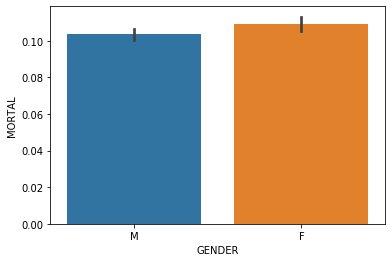

In [58]:
sns.barplot(x = 'GENDER', y = 'MORTAL', data=df_m3)

**ADMITTION_TYPE**

In [39]:
df_m3[['ADMISSION_TYPE', 'MORTAL']].groupby(['ADMISSION_TYPE'], as_index=False).mean().sort_values(by='MORTAL', ascending=False)

,ADMISSION_TYPE,MORTAL
1,EMERGENCY,0.136065
3,URGENT,0.126556
0,ELECTIVE,0.031458
2,NEWBORN,0.007778


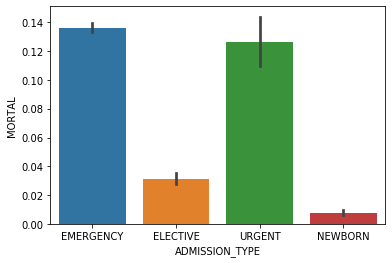

In [64]:
sns.barplot(x = 'ADMISSION_TYPE', y = 'MORTAL', data=df_m3)

**MARITAL_STATUS**

In [40]:
df_m3[['MARITAL_STATUS', 'MORTAL']].groupby(['MARITAL_STATUS'], as_index=False).mean().sort_values(by='MORTAL', ascending=False)

,MARITAL_STATUS,MORTAL
5,UNKNOWN (DEFAULT),0.192513
6,WIDOWED,0.152986
2,MARRIED,0.115862
0,DIVORCED,0.107741
3,SEPARATED,0.101142
4,SINGLE,0.088694
1,LIFE PARTNER,0.000000


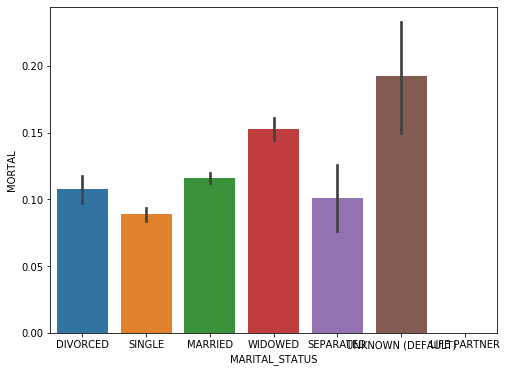

In [41]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'MARITAL_STATUS', y = 'MORTAL', data=df_m3)

**Q**: According to the analysis, how should we deal with the missing(unknown) values? Shall we keep this feature at all?

We can do multi-variable comparison (#Correlating)

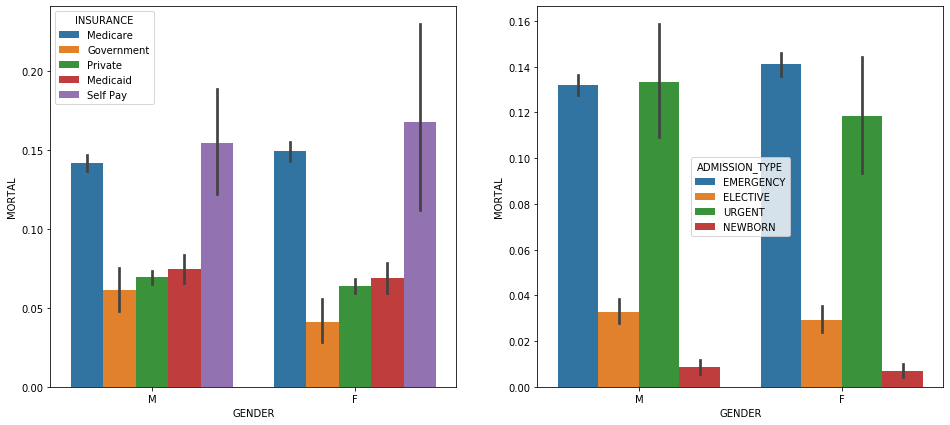

In [42]:
fig, qaxis = plt.subplots(1,2,figsize=(16,7))
sns.barplot(x = 'GENDER', y = 'MORTAL', hue = 'INSURANCE', data=df_m3, ax = qaxis[0])
# axis1.set_title('GENDER vs MARITAL_STATUS Mortal Comparison')

sns.barplot(x = 'GENDER', y = 'MORTAL', hue = 'ADMISSION_TYPE', data=df_m3, ax  = qaxis[1])
# axis1.set_title('Sex vs Pclass Survival Comparison')

### Numeric features

#### Age

In [0]:
# We can save the the intermediate result 
df_m3=pd.read_csv('df_m3.csv')

In [46]:
df_m3.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'DIAGNOSIS', 'MARITAL_STATUS', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'ETHNICITY', 'GENDER', 'DOB', 'LOS', 'CALLOUT_COUNT',
       'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT',
       'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT',
       'MICRO_COUNT', 'AGE', 'MORTAL'],
      dtype='object')

**Histgram plotting**

A histogram is a graphical display of data using bars of different heights. In a histogram, each bar groups numbers into ranges. Taller bars show that more data falls in that range. A histogram displays the shape and spread of continuous sample data. 

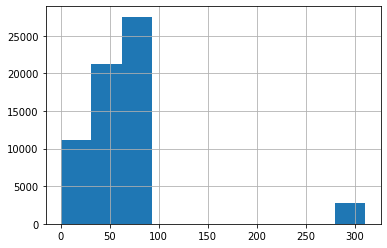

In [43]:
df_m3.AGE.hist()

Clearly, there is an outlier which should be removed

**Boxplot**

Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).
![alt text](https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png)

{'boxes': [<matplotlib.lines.Line2D at 0x7f49675228d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f49675311d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4967531ef0>],
 'means': [<matplotlib.lines.Line2D at 0x7f4967531ba8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4967531860>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f4967522b00>,
  <matplotlib.lines.Line2D at 0x7f4967522e48>]}

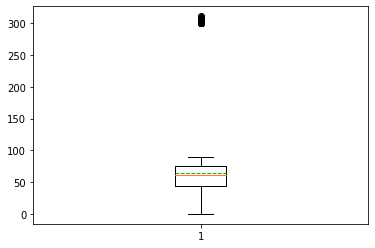

In [98]:
plt.boxplot(df_m3['AGE'], showmeans = True, meanline = True)

Remove the outlier(#Correcting)

In [49]:
df_m3[df_m3['AGE']>150]

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,MORTAL
3,32339,181355,EMERGENCY,2110-07-29,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,3.75,7.50,0.50,2.00,51.75,0.00,5.25,5.00,1.00,0.00,300,0
5,41420,143206,EMERGENCY,2147-01-06,2147-01-08 18:30:00,NaN,ACUTE SUBDURAL HEMATOMA,WIDOWED,Medicare,ENGL,JEWISH,WHITE,F,1847-01-06,1.0430,1.0,1.25,10.00,0.00,0.00,16.25,0.00,3.25,5.75,0.75,0.50,300,0
8,58899,177890,EMERGENCY,2102-04-04,2102-04-10 16:00:00,NaN,THREATENED LEFT LOWER EXTREMITY,SINGLE,Medicare,ENGL,NOT SPECIFIED,WHITE,F,1802-04-04,1.8137,2.0,2.50,25.00,2.00,4.50,93.75,0.00,30.75,10.75,1.50,0.75,300,0
9,56165,135230,EMERGENCY,2179-07-03,2179-07-09 12:45:00,NaN,? TB,SEPARATED,Medicare,ENGL,NOT SPECIFIED,WHITE,M,1879-07-03,2.2286,1.0,1.00,2.56,0.00,0.78,18.89,0.00,3.33,1.78,0.67,1.00,300,0
17,25835,162690,EMERGENCY,2193-07-21,2193-07-24 16:23:00,NaN,URINARY TRACT INFECTION;PYELONEPHRITIS,WIDOWED,Medicare,ENGL,JEWISH,WHITE,F,1888-03-12,1.0834,1.0,6.50,13.25,0.00,1.00,37.50,0.00,7.75,3.50,1.00,2.25,305,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62024,5099,158849,URGENT,2117-12-12,2117-12-29 18:18:00,NaN,RECTAL PROLAPSE,WIDOWED,Medicare,NaN,JEWISH,WHITE,F,1817-12-12,1.9208,0.0,2.25,0.00,2.25,0.00,153.25,154.00,0.00,31.50,1.75,5.50,300,0
62025,5099,158849,URGENT,2117-12-12,2117-12-29 18:18:00,NaN,RECTAL PROLAPSE,WIDOWED,Medicare,NaN,JEWISH,WHITE,F,1817-12-12,3.8771,0.0,0.56,0.00,0.56,0.00,38.31,38.50,0.00,7.88,0.44,1.38,300,0
62269,7297,115630,EMERGENCY,2156-08-25,2156-08-27 17:41:00,NaN,CONGESTIVE HEART FAILURE;PNEUMONIA;HYPERTENSION,UNKNOWN (DEFAULT),Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,F,1856-08-25,2.2646,0.0,1.00,0.00,0.11,0.00,17.78,14.22,0.00,3.00,0.22,0.33,300,0
62272,19023,148048,EMERGENCY,2105-01-04,2105-01-08 14:06:00,NaN,STROKE,NaN,Medicare,RUSS,NaN,UNKNOWN/NOT SPECIFIED,F,1805-01-04,0.9938,0.0,5.00,0.00,0.00,0.00,125.00,55.00,0.00,22.00,3.00,1.00,300,0


In [0]:
df_m3= df_m3[df_m3['AGE']<10]

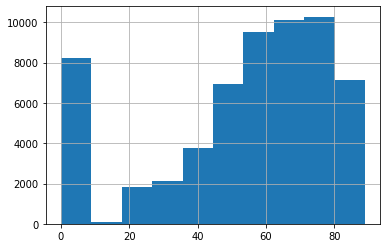

In [101]:
df_m3.AGE.hist()

{'boxes': [<matplotlib.lines.Line2D at 0x7f496750b6a0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f496750bef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4967518c50>],
 'means': [<matplotlib.lines.Line2D at 0x7f4967518908>],
 'medians': [<matplotlib.lines.Line2D at 0x7f49675185c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f496750b7f0>,
  <matplotlib.lines.Line2D at 0x7f496750bba8>]}

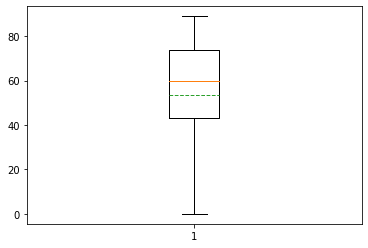

In [100]:
plt.boxplot(df_m3['AGE'], showmeans = True, meanline = True)

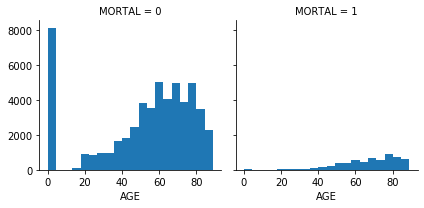

In [19]:
g = sns.FacetGrid(df_m3, col='MORTAL')
g.map(plt.hist, 'AGE', bins=20)

**Q:** What conclusion can you get from the figure above? Shall we remove the infant patients(Age<1) from our training dataset?

#### PROC_COUNT

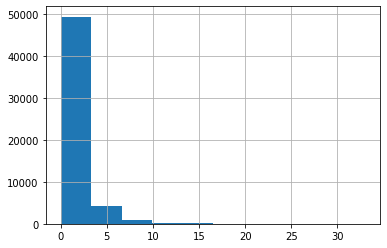

In [94]:
df_m3.PROC_COUNT.hist()

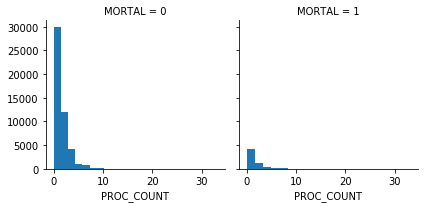

In [97]:
g = sns.FacetGrid(df_m3, col='MORTAL')
g.map(plt.hist, 'PROC_COUNT', bins=20)